In [1]:
import findspark
findspark.init('/usr/local/spark')

ModuleNotFoundError: No module named 'findspark'

In [1]:
from pyspark import SparkContext, SparkConf, SQLContext
from operator import add

import pandas as pd
import re
import numpy as np
import hashlib
import csv

from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinHashLSH
# from pyspark.mllib.linalg import Vectors

In [2]:
conf = SparkConf()
master = "local[*]"
conf.set("spark.app.name", "bigwj")
conf.set("spark.master", master)
conf.set("spark.executor.cores", 10)
conf.set("spark.executor.instances", 1)
conf.set("spark.executor.memory", "40g")
conf.set('spark.driver.memory', '45G')
conf.set('spark.driver.maxResultSize', '10G')
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
sc = SparkContext(conf=conf) 
questionFile=sc.textFile("../../Questions.csv")
answerFile=sc.textFile("../../Answers.csv")
tagFile = sc.textFile("../../Tags.csv")
stopWordsFile = sc.textFile("stopwords.txt")
print("finished")

finished


In [3]:
#Read sample of question.csv(5%), generate the keywords list to focus on

In [4]:
questionWithHeader = questionFile.map(lambda line: line.split(",")).filter(lambda line: len(line)>1)
header = questionWithHeader.first() #extract header
question = questionWithHeader.filter(lambda x: x != header)
print(question.count())

1264216


In [5]:
questionSample=question.sample(False,0.05,81)
questionLower = questionSample.map(lambda x: (x[0], re.sub("<.*?>", " ", (x[5]+x[6]).lower())))
def f(x): return re.sub('[^a-zA-Z0-9\']+', ' ', x)
questionLower = questionLower.mapValues(f)
def f2(x): return x.split(" ")
questionPairRaw = questionLower.flatMapValues(f2)
print(questionPairRaw.count())

12511645


In [6]:
stopWordsList = stopWordsFile.collect()
questionPair=questionPairRaw.filter(lambda x: x[1] not in stopWordsList)
questionPairfilter=questionPair.filter(lambda x:x[1]!="")
questionPairStage1 = questionPairfilter.map(lambda x:(x[0]+"@"+x[1],1)).reduceByKey(add)
N = len(questionPair.countByKey())
print(N)

63340


In [7]:
questionPairStage2MapPhase = questionPairStage1.map(lambda x:(x[0].split("@")[1],x[0].split("@")[0]+"="+str(x[1])))
stage2Map = questionPairStage2MapPhase.countByKey()
questionPairStage2 = questionPairStage2MapPhase.map(lambda x:(x[0]+"@"+x[1].split("=")[0],(1+np.log(int(x[1].split("=")[1])))*np.log(N/stage2Map.get(x[0]))))
questionPairStage3MapPhase = questionPairStage2.map(lambda x:(x[0].split("@")[1],x[0].split("@")[0]+"="+str(x[1])))
def f3_1(a,b): return float(a)+float(b.split("=")[1])*float(b.split("=")[1])
def f3_2(a,b): return float(a)+float(b)
questionPairStage3AggByKey = questionPairStage3MapPhase.aggregateByKey(0.0,f3_1,f3_2)
print(questionPairStage3AggByKey.count())

63340


In [8]:
questionPairStage3AggByKeysqr = questionPairStage3AggByKey.map(lambda x:(x[0],np.sqrt(x[1])))
stage3Map = questionPairStage3AggByKeysqr.collectAsMap()
questionPairStage3 = questionPairStage3MapPhase.map(lambda x:(x[0],x[1].split("=")[0]+"="+str(float(x[1].split("=")[1])/stage3Map.get(x[0]))))
num_keywords = 7
def f4_1(a,b):
    c=[]
    for i in range(num_keywords):
        if float(b.split("=")[1])>float(a[i].split("=")[1]):
            a[i]=b
            break
    return a
def f4_2(a,b):
    for i in range(num_keywords): #b
        for j in range(num_keywords): #a
            if float(b[i].split("=")[1])>float(a[j].split("=")[1]):
                a[j] = b[i]
                break
    return a
questionPairStage4 = questionPairStage3.aggregateByKey(["a=0","b=0","c=0","d=0","e=0","f=0","g=0"],f4_1,f4_2)
print(questionPairStage4.count())
questionPairStage4.take(5)

63340


[('432500',
  ['2005=0.4025217297951289',
   'helptext=0.27349687887229185',
   'feature=0.2666456216421531',
   'sql=0.2468161077629039',
   'procedures=0.18900209536441626',
   'enterprise=0.18009071452331646',
   'studio=0.11578629361809115']),
 ('435980',
  ['recompile=0.3558572862285933',
   "recompile'=0.3243447697293484",
   'justifiable=0.3243447697293484',
   "'with=0.2633426554112979",
   'health=0.20678638100994748',
   'commented=0.1720051433839007',
   'find=0.10636857817414502']),
 ('525430',
  ['gameconfig=0.3846834629964711',
   'getscreensize=0.20915349295126862',
   'getextendedstate=0.1474200482653507',
   'graphicsconfiguration=0.1474200482653507',
   'screenmaximized=0.1474200482653507',
   '3200x1200=0.1474200482653507',
   'windowy=0.13817789251386475']),
 ('767570',
  ['apikey=0.27488256162241737',
   "'getbyshortname'=0.26984307391898",
   'emp=0.2021670645524186',
   'getemployeebyshortname=0.12858167055251382',
   "'getbyid'=0.12858167055251382",
   "'emprest

In [9]:
#Get the keywords set for threshold 0.4, the threshold can be adjusted.

In [10]:
def fmap1(x):
    output=""
    for i in range(num_keywords):
        y=x[1][i].split("=")
        if float(y[1])>0.4:
           output+=y[0]+";"
    return ("key",output)
keywordlist=questionPairStage4.map(fmap1).reduceByKey(add)
keywords=keywordlist.take(1)
words=keywords[0][1][:-1]
keywordset=set(words.split(";"))
print(len(keywordset))
print(keywordset)

26022
{'updateround', 'monocle', 'fancybox', 'sievednumbers', 'slides', 'vec1', 'height0', 'testobject', 'tornado', 'keypress', "loadingpanel'", 'rerendering', 'samplecode', 'e8e8e8', 'glist', 'skype', 'crisis', '1442', 'radius', 'gregwinter', 'gameoverviewcontroller', 'top5', 'onsharetargetactivated', 'endpoints', 'etoken', 'euclidean', 'content3', 'dataheading', 'strtoupper', 'gcda', 'htpasswd', 'scaffolded', 'tabletocsv', 'arrlen', 'pointed', 'zoomtoplace', 'microservices', 'languages', 'bintree', 'bbc', 'browserstack', 'dis', 'freesurfer', 'settimedelegate', 'pitches', 'tampedmonkey', 'somedata', 'openned', 'odp', 'beginreceivingremotecontrolevents', 'accessentity', 'stoppow', 'getproperty', 'intersectionwith', 'ip', 'getbrowserfordocument', 'trackbar', 'polyline', 'spacearray', 'smtp', 'alias', 'fingerprint', 'spree', 'manifold', 'icmp', 'booking', "'voiture'", 'totalscore', 'daysdt', 'strutils', 'stauts', 'gitconfig', 'sys32path', 'tamer', 'matchingscripts', 'moment', 'auxiliary'

In [11]:
#turn oringinal question pairs to pairs only keep the keywords,get 7 keywords for each question

In [12]:
questionLower = question.map(lambda x: (x[0], re.sub("<.*?>", " ", (x[5]+x[6]).lower())))
def f(x): return re.sub('[^a-zA-Z0-9\']+', ' ', x)
questionLower = questionLower.mapValues(f)
def f2(x): return x.split(" ")
questionPairRaw = questionLower.flatMapValues(f2)
questionPair=questionPairRaw.filter(lambda x: x[1] in keywordset)
print(questionPair.count())

63607776


In [13]:
questionPairfilter=questionPair.filter(lambda x:x[1]!="")
questionPairStage1 = questionPairfilter.map(lambda x:(x[0]+"@"+x[1],1)).reduceByKey(add)
N = len(questionPair.countByKey())
questionPairStage2MapPhase = questionPairStage1.map(lambda x:(x[0].split("@")[1],x[0].split("@")[0]+"="+str(x[1])))
stage2Map = questionPairStage2MapPhase.countByKey()
questionPairStage2 = questionPairStage2MapPhase.map(lambda x:(x[0]+"@"+x[1].split("=")[0],(1+np.log(int(x[1].split("=")[1])))*np.log(N/stage2Map.get(x[0]))))
print(questionPairStage2.count())
print(questionPairStage2.take(5))

26826499
[('statement@80', 6.213796737970658), ('log@650', 2.823660249534865), ('ordering@1610', 6.270827857079348), ('asax@2770', 7.173611890114138), ('ends@2770', 5.225787019213081)]


In [14]:
questionPairStage3MapPhase = questionPairStage2.map(lambda x:(x[0].split("@")[1],x[0].split("@")[0]+"="+str(x[1])))
def f3_1(a,b): return float(a)+float(b.split("=")[1])*float(b.split("=")[1])
def f3_2(a,b): return float(a)+float(b)
questionPairStage3AggByKey = questionPairStage3MapPhase.aggregateByKey(0.0,f3_1,f3_2)
questionPairStage3AggByKeysqr = questionPairStage3AggByKey.map(lambda x:(x[0],np.sqrt(x[1])))
stage3Map = questionPairStage3AggByKeysqr.collectAsMap()
print(stage3Map.get('90'))

18.138628867423357


In [15]:
questionPairStage3 = questionPairStage3MapPhase.map(lambda x:(x[0],x[1].split("=")[0]+"="+str(float(x[1].split("=")[1])/stage3Map.get(x[0]))))

num_keywords = 7
def f4_1(a,b):
    c=[]
    for i in range(num_keywords):
        if float(b.split("=")[1])>float(a[i].split("=")[1]):
            a[i]=b
            break
    return a
def f4_2(a,b):
    for i in range(num_keywords): #b
        for j in range(num_keywords): #a
            if float(b[i].split("=")[1])>float(a[j].split("=")[1]):
                a[j] = b[i]
                break
    return a
questionPairStage4 = questionPairStage3.aggregateByKey(["a=0","b=0","c=0","d=0","e=0","f=0","g=0"],f4_1,f4_2)
print(questionPairStage4.take(5))

[('31023980', ['mandrill=0.5012599819232673', 'setname=0.28122956090094503', 'block=0.22252172948164717', 'hello=0.17924942434202162', 'emails=0.1481657080551299', 'arraylist=0.11629531537773925', 'sending=0.11189960110670119']), ('36514380', ['mysqld=0.3867022401464816', '44=0.3189936957829676', 'buffer=0.22149247413445008', 'future=0.20709864260525043', 'recover=0.20002703967073224', 'disabled=0.14325181191183206', 'log=0.13640641033035308']), ('37311550', ['argparse=0.7201919666120632', 'argument=0.36334911124517005', 'parser=0.35517503828127034', 'd=0', 'e=0', 'f=0', 'g=0']), ('18471210', ['spain=0.7815221653032852', 'language=0.36544826754710613', 'posts=0.24189482098931772', 'settings=0.2111333730342773', 'e=0', 'f=0', 'g=0']), ('2885370', ['cn=0.3386022852715114', 'dom=0.25936726473501964', '16px=0.18160673592458018', 'classname=0.17275369777961475', 'float=0.139370637364722', 'pointer=0.13275247351931413', 'tr=0.11665637815908587'])]


In [16]:
outMap=questionPairStage4.collectAsMap()
tagWithHeader = tagFile.map(lambda line: line.split(",")).filter(lambda line: len(line)>1)
header = tagWithHeader.first() #extract header
tag = tagWithHeader.filter(lambda x: x != header)
tagLower = tag.map(lambda x: (x[0], x[1].lower()))
def f0(x): return re.sub('[^a-zA-Z]+', '', x)
tagLower = tagLower.mapValues(f0)
tag_1000 = tagLower.map(lambda x: (x[0], x[1]+"=1000"))
questionPairStage5=questionPairStage4.map(lambda x:(x[0],x[1][0]+":"+x[1][1]+":"+x[1][2]+":"+x[1][3]+":"+x[1][4]+":"+x[1][5]+":"+x[1][6]) )
print(questionPairStage5.take(5))

[('31023980', 'mandrill=0.5012599819232673:setname=0.28122956090094503:block=0.22252172948164717:hello=0.17924942434202162:emails=0.1481657080551299:arraylist=0.11629531537773925:sending=0.11189960110670119'), ('36514380', 'mysqld=0.3867022401464816:44=0.3189936957829676:buffer=0.22149247413445008:future=0.20709864260525043:recover=0.20002703967073224:disabled=0.14325181191183206:log=0.13640641033035308'), ('37311550', 'argparse=0.7201919666120632:argument=0.36334911124517005:parser=0.35517503828127034:d=0:e=0:f=0:g=0'), ('18471210', 'spain=0.7815221653032852:language=0.36544826754710613:posts=0.24189482098931772:settings=0.2111333730342773:e=0:f=0:g=0'), ('2885370', 'cn=0.3386022852715114:dom=0.25936726473501964:16px=0.18160673592458018:classname=0.17275369777961475:float=0.139370637364722:pointer=0.13275247351931413:tr=0.11665637815908587')]


In [17]:
#union the keywords of each question 

In [18]:
questionPairStage6=questionPairStage5.union(tag_1000)
def f6_1(a,b):
    return a+":"+b
def f6_2(a,b):
    return a+b
questionPairStage6=questionPairStage6.aggregateByKey("",f6_1,f6_2).map(lambda x: (x[0], x[1][1:]))

In [19]:
print(questionPairStage6.take(10))

[('39184030', "teamcity=0.45650428958324246:nuget=0.22330053569111674:'a'=0.20776896471755765:dependency=0.202494258481889:chain=0.1954913131686087:snapshot=0.19440662923684707:from'=0.16650127209702012:teamcity=1000:octopusdeploy=1000"), ('11415340', 'tracking=0.22403828047894667:shopname=0.22017646054992643:icons=0.2149358787688903:contact=0.1774709024392878:underline=0.14902309903488592:studio=0.1312584907174281:href=0.12270941954537161:php=1000:syntax=1000'), ('8196450', 'obj=0.46024149286443583:async=0.2920709585418119:image=0.254930929364479:bind=0.25252629021688244:element=0.19486339269567893:request=0.10239758038672746:g=0:jquery=1000'), ('32160900', 'slider=0.33565560595809313:btn=0.30806227730087077:floor=0.20487204882565263:product=0.17639060422445474:addtocart=0.17602643122363976:angularjs=0.16555906976860718:href=0.1641698341549854:angularjs=1000:slider=1000'), ('13028340', 'cells=0.4167693287608893:tableview=0.41064664630049685:sections=0.28574032123142573:cell=0.26280304

In [20]:
# get keyword and tag set
questionKeywordAndTag = questionPairStage6.flatMapValues(lambda x: x.split(":")).filter(lambda x: float(x[1].split("=")[1]) > 0)
questionKeywordAndTag = questionKeywordAndTag.map(lambda x: (x[0], (x[1].split("=")[0], x[1].split("=")[1])))
print(questionKeywordAndTag.take(5))

questionKeywordAndTagSet = set(questionKeywordAndTag.map(lambda x: x[1][0]).collect())
print(len(questionKeywordAndTagSet))

[('39184030', ('teamcity', '0.45650428958324246')), ('39184030', ('nuget', '0.22330053569111674')), ('39184030', ("'a'", '0.20776896471755765')), ('39184030', ('dependency', '0.202494258481889')), ('39184030', ('chain', '0.1954913131686087'))]
54596


In [21]:
# get hash value of each keyword to hash questions into different buckets
partitionNum = 100
def hashKeyword(x):
    return (int(hashlib.sha1(x.encode()).hexdigest(), 16) % (10 ** 8)) % partitionNum

questionHashedKeywordAndTag = questionKeywordAndTag.map(lambda x: (x[0], (hashKeyword(x[1][0]), x[1][1])))
print(questionHashedKeywordAndTag.take(5))

[('39184030', (18, '0.45650428958324246')), ('39184030', (36, '0.22330053569111674')), ('39184030', (9, '0.20776896471755765')), ('39184030', (23, '0.202494258481889')), ('39184030', (5, '0.1954913131686087'))]


In [22]:
# group questions with same hash value into same bucket
questionPartitions = questionHashedKeywordAndTag.map(lambda x: (x[1][0], x[0]))
questionPartitions = questionPartitions.groupByKey().sortBy(lambda x: x[0]).map(lambda x: (x[0], set(x[1])))
print(questionPartitions.count())

100


In [23]:
# load new question and remove html tags and punctuations
newQuestion = sc.wholeTextFiles("new.txt")
newQuestion = newQuestion.map(lambda x: re.sub('\n', ' ', x[1]))
newQuestion = newQuestion.map(lambda x: re.sub('<.*?>', ' ', x.lower()))
newQuestion = newQuestion.map(lambda x: re.sub('[^a-zA-Z0-9\']+', ' ', x))

# calculate ti-idf for words in keyword and tag set
newQuestionKeywordsStageOne = newQuestion.flatMap(lambda x: x.lower().split(" ")).filter(lambda x: x != '' and x in questionKeywordAndTagSet).map(lambda x: (x, 1)).reduceByKey(add).map(lambda x: (x[0], 'new=' + str(x[1])))
print(newQuestionKeywordsStageOne.count())

newQuestionKeywordsStageTwoMap = newQuestionKeywordsStageOne.union(questionPairStage2MapPhase).countByKey()
newQuestionKeywordsStageTwo = newQuestionKeywordsStageOne.map(lambda x: (x[0], (1 + np.log(int(x[1].split("=")[1]))) * np.log((N + 1)/newQuestionKeywordsStageTwoMap.get(x[0]))))
print(newQuestionKeywordsStageTwo.count())

newQuestionKeywordsStageThreeSquare = newQuestionKeywordsStageTwo.map(lambda x: np.square(x[1])).reduce(add)
newQuestionKeywordsStageThree = newQuestionKeywordsStageTwo.map(lambda x: (x[0], x[1]/np.sqrt(newQuestionKeywordsStageThreeSquare)))
print(newQuestionKeywordsStageThree.take(5))

keywordAndTagSet = keywordset.union(tagLower.values().collect())
newQuestionKeywordsStageFour = newQuestionKeywordsStageThree.filter(lambda x: x[0] in keywordAndTagSet).sortBy(lambda x: -x[1])
print(newQuestionKeywordsStageFour.take(5))

13
13
[('using', 0.2366398584958564), ('spark', 0.17661318146802954), ('to', 0.2366398584958564), ('find', 0.2366398584958564), ('similarity', 0.2366398584958564)]
[('i', 0.40066610922036366), ('when', 0.40066610922036366), ('code', 0.40066610922036366), ('a', 0.40066610922036366), ('using', 0.2366398584958564)]


In [24]:
# get top 5 relevant words only
keywordNum = 5
newQuestionKeywords = newQuestionKeywordsStageFour.zipWithIndex().filter(lambda x: x[1] < keywordNum).keys()
print(newQuestionKeywords.take(keywordNum))

[('i', 0.40066610922036366), ('when', 0.40066610922036366), ('code', 0.40066610922036366), ('a', 0.40066610922036366), ('using', 0.2366398584958564)]


In [25]:
# hash each relevant word to find correxponding buckets to form cadidate question set
newQuestionHashedKeywords = newQuestionKeywords.map(lambda x: hashKeyword(x[0])).collect()
print(newQuestionHashedKeywords)
bucketQuestions = questionPartitions.filter(lambda x: x[0] in newQuestionHashedKeywords).map(lambda x: x[1]).reduce(lambda a, b: a.union(b))
print(len(bucketQuestions))

[42, 29, 86, 52, 80]
383808


In [26]:
# union new question to cadidate question set
candidateSimilarQuestions = questionLower.filter(lambda x: x[0] in bucketQuestions)
candidateSimilarQuestions = newQuestion.map(lambda x: ['0', x]).union(candidateSimilarQuestions)
candidateSimilarQuestions = candidateSimilarQuestions.map(lambda x: (x[0], list(filter(None, x[1].split(" ")))))
print(candidateSimilarQuestions.count())

# generate shingles
shingleLength = 2
candidateQuestionShingles = candidateSimilarQuestions.map(lambda x: (x[0], [" ".join(x[1][i: i + shingleLength]) for i in range(len(x[1]) - shingleLength + 1)]))
print(candidateQuestionShingles.take(1))

383809
[('0', ["i'm using", 'using spark', 'spark to', 'to find', 'find similarity', 'similarity but', 'but i', 'i keep', 'keep getting', 'getting spark', 'spark stackoverflowerror', 'stackoverflowerror when', 'when i', 'i run', 'run my', 'my code', 'code on', 'on a', 'a big', 'big dataset', 'dataset 40k', '40k entries', 'entries when', 'when running', 'running the', 'the code', 'code on', 'on a', 'a small', 'small number', 'number of', 'of entries', 'entries it', 'it works', 'works fine', 'fine though'])]


In [27]:
sqlContext = SQLContext(sc)

In [28]:
# hash shingles into indexes 0~99999999; index may be duplicate
allShingles = candidateQuestionShingles.flatMap(lambda x: [(x[0], shingle) for shingle in x[1]])
allShingles = sqlContext.createDataFrame(allShingles, ["id", "shingle"])

def hashShingle(shigle):
    return (int(hashlib.sha1(shigle.encode()).hexdigest(), 16) % (10 ** 5))

hashShingleUdf = udf(hashShingle, IntegerType())
allIndexedShingles = allShingles.withColumn("shingleIndex", hashShingleUdf(allShingles.shingle))

allIndexedShingles.take(5)

[Row(id='0', shingle="i'm using", shingleIndex=7528),
 Row(id='0', shingle='using spark', shingleIndex=51426),
 Row(id='0', shingle='spark to', shingleIndex=98205),
 Row(id='0', shingle='to find', shingleIndex=96213),
 Row(id='0', shingle='find similarity', shingleIndex=51161)]

In [29]:
# get shingle size for creating vectors
shingleSize = allIndexedShingles.agg({"shingleIndex": "max"}).collect()[0][0]
print(shingleSize)

99999


In [30]:
# create vector for shingles of each question
allIndexedShingles = allIndexedShingles.rdd.map(lambda x: (x[0], x[2]))
allIndexedShingles = allIndexedShingles.groupByKey()
allIndexedShingles = allIndexedShingles.map(lambda x: (int(x[0]), sorted(list(set(x[1])))))
allIndexedShingles = allIndexedShingles.map(lambda x: (x[0], (x[1], [1] * len(x[1]))))
allIndexedShingles = allIndexedShingles.map(lambda x: (x[0], Vectors.sparse((shingleSize + 1), x[1][0], x[1][1])))
print(allIndexedShingles.take(1))

[(11820, SparseVector(100000, {645: 1.0, 919: 1.0, 2855: 1.0, 3020: 1.0, 3675: 1.0, 5270: 1.0, 5730: 1.0, 7019: 1.0, 7199: 1.0, 8461: 1.0, 9047: 1.0, 9469: 1.0, 11499: 1.0, 11774: 1.0, 13483: 1.0, 14170: 1.0, 14626: 1.0, 14806: 1.0, 15534: 1.0, 15981: 1.0, 16242: 1.0, 16453: 1.0, 17146: 1.0, 20366: 1.0, 20420: 1.0, 20802: 1.0, 21238: 1.0, 21356: 1.0, 21975: 1.0, 22557: 1.0, 22815: 1.0, 24331: 1.0, 24555: 1.0, 24580: 1.0, 24790: 1.0, 25125: 1.0, 25976: 1.0, 26156: 1.0, 26510: 1.0, 26561: 1.0, 26826: 1.0, 27775: 1.0, 29143: 1.0, 29615: 1.0, 29857: 1.0, 30000: 1.0, 31281: 1.0, 31313: 1.0, 32611: 1.0, 34112: 1.0, 34710: 1.0, 36370: 1.0, 36939: 1.0, 37921: 1.0, 40028: 1.0, 40370: 1.0, 40582: 1.0, 41476: 1.0, 43101: 1.0, 44023: 1.0, 44032: 1.0, 45353: 1.0, 45356: 1.0, 45850: 1.0, 46623: 1.0, 46781: 1.0, 47992: 1.0, 48607: 1.0, 49336: 1.0, 49432: 1.0, 50359: 1.0, 52025: 1.0, 52994: 1.0, 55331: 1.0, 56371: 1.0, 57904: 1.0, 59180: 1.0, 59241: 1.0, 60745: 1.0, 60834: 1.0, 61037: 1.0, 61164: 1.0,

In [36]:
# apply minhash and lsh to find similar questions with threshold 0.99
threshold = 0.99

key = allIndexedShingles.filter(lambda x: x[0] == 0)
key = sqlContext.createDataFrame(key, ["id", "shingles"])

existingQuestions = allIndexedShingles.filter(lambda x: x[0] != 0)
existingQuestions = sqlContext.createDataFrame(existingQuestions, ["id", "shingles"])
print(existingQuestions.count())

minhashLsh = MinHashLSH(inputCol="shingles", outputCol="hashes", seed=12345)
model = minhashLsh.fit(existingQuestions)

similarQuestions = model.approxSimilarityJoin(existingQuestions, key, threshold, distCol="JaccardDistance")

# format similar questions in <question, similarity> pairs
similarQuestions = similarQuestions.rdd.map(lambda x: (x[0], x[2]))
similarQuestions = similarQuestions.map(lambda x: (x[0].asDict().get('id'), (1 - x[1]))).sortBy(lambda x: -x[1])

print(similarQuestions.take(1))

383808
[(9001330, 0.02941176470588236)]


In [37]:
# load questions and answers in dataFrame
questionDataFrame = sqlContext.read.format("csv").options(header="true").load("../../Questions.csv")
answerDataFrame = sqlContext.read.format("csv").options(header="true").load("../../Answers.csv")

print("finish reading source files")

finish reading source files


In [38]:
# calculate weighted_norm_upvotes for each answer of similar questions
similarQuestionJaccardSimilarity = similarQuestions.collectAsMap()
similarQuestions = similarQuestions.map(lambda x: x[0]).collect()

similarQuestionDataFrame = questionDataFrame.filter(questionDataFrame.Id.isin(similarQuestions))
similarQuestionDataFrame = similarQuestionDataFrame.join(answerDataFrame, questionDataFrame.Id == answerDataFrame.ParentId).select(questionDataFrame.Id, questionDataFrame.Body, answerDataFrame.Body, answerDataFrame.Score)
print(similarQuestionDataFrame.take(1))

similarQuestionAnswers = similarQuestionDataFrame.rdd.map(lambda x: (x[0], ((x[1].replace("\"\"", "\'").replace("\"", ""), x[2].replace("\"\"", "\'").replace("\"", "")), int(x[3]))))
similarQuestionAnswerScoreSqrt = similarQuestionAnswers.map(lambda x: (x[0], np.square(x[1][1]))).reduceByKey(add).map(lambda x:(x[0], np.sqrt(x[1])))
similarQuestionAnswerScoreSqrt = similarQuestionAnswerScoreSqrt.collectAsMap()

similarQuestionAnswerScoreNorm = similarQuestionAnswers.map(lambda x: (x[0], (x[1][0], x[1][1]/similarQuestionAnswerScoreSqrt.get(x[0]))))
similarQuestionAnswerScoreNorm = similarQuestionAnswerScoreNorm.map(lambda x: (x[0], (x[1][0], x[1][1] * similarQuestionJaccardSimilarity.get(int(x[0])))))
print(similarQuestionAnswerScoreNorm.take(1))

[Row(Id='12334740', Body='<p>Zend views usually render instantly; but with a large dataset; 1500 objects into a xml view; it takes 2-3 seconds which is unacceptable for my app. Any suggestions would be greatly appreciated.</p> ', Body="<p><strong>600 KB can or can not force an application to execute slow.</strong> The execution time depends on the actual script; its persistence layer; connections from web- to database-server and more aspect. Thus:</p>  <p>First of all; instrument your application in such a way; that it <strong>computes the time taken by the server-side script</strong>.</p>  <p>For example; rename <code>index.php</code> to <code>realIndex.php</code> and create a new <code>index.php</code> like this:</p>  <pre><code>$startTime = microtime(TRUE);  require_once( dirname( __FILE__ ) . '/realIndex.php' );  $endTime = microtime(TRUE);  echo '&lt;hr /&gt;Time taken: ' . ( $endTime - $startTime ) . ' micros'; </code></pre>  <p>Certainly; this approach is trivial and does not wo

In [39]:
# take top 10 answers as suggested answers
answerCount = 10
similarQuestionAnswerSorted = similarQuestionAnswerScoreNorm.map(lambda x: x[1]).sortBy(lambda x: -x[1])
similarQuestionAnswerTop = similarQuestionAnswerSorted.take(answerCount)

In [43]:
# output suggested answers
with open('suggested_answers.csv', 'w', encoding='utf-8') as suggestedAnswers:
        writer = csv.writer(suggestedAnswers, delimiter=',')
        writer.writerow(['Rank', 'Original Question', 'Answer'])
        for idx, questionAnswer in enumerate(similarQuestionAnswerTop):
            writer.writerow([idx + 1, questionAnswer[0][0], questionAnswer[0][1]])
            
for idx, questionAnswer in enumerate(similarQuestionAnswerTop):
    print("Rank: " + str(idx + 1))
    print("Original Question: " + questionAnswer[0][0])
    print("Answer: " + questionAnswer[0][1])
    print()

Rank: 1
Original Question: <p>I got a notification to upgrade eclipse yesterday so I did it.  When I started it up again today it ask for another upgrade.  So I looked through the list and most of the dates were pretty old.  I did the upgrade and the shut down and started eclipse and it asked for the same upgrades again.  Should I just do a clean install?  Why is this happening.</p> 
Answer: <p>Try to run eclipse with the <code>-clean</code> flag. To do that; create a shortcut to eclipse and add <code>-clean</code> at the end at the call.</p>  <p>Anyway; a fresh install will be great!</p> 

Rank: 2
Original Question: <p>I am creating an application that when you click a button; it waits 10 seconds and executes a certain keystroke via SendKeys. The problem is - it needs to let user move his mouse pointer thorough the windows (ex. select a text box in web browser). So; when i try</p>  <pre><code>System.Threading.Thread.Sleep(10000); </code></pre>  <p>It isn't working for me; because it f

In [44]:
#count top 10 keyword:by tag and by word
#(word) title+body->upvotes
#(k-items) title+body->upvotes

In [45]:
#count top 10 keyword by tag

In [46]:
tagWords=tagLower.map(lambda x:(x[1],1))
tagCounts=tagWords.reduceByKey(add)
tagCounts.take(10)

[('flex', 3307),
 ('actionscript', 5112),
 ('svn', 2361),
 ('tortoisesvn', 441),
 ('sitemap', 157),
 ('algorithm', 6837),
 ('colors', 1257),
 ('colorspace', 26),
 ('c', 178780),
 ('scripting', 1030)]

In [47]:
tagSorted = tagCounts.sortBy(lambda x: -x[1])
tagSorted.take(100)

[('c', 178780),
 ('javascript', 124156),
 ('java', 116276),
 ('php', 99151),
 ('android', 90795),
 ('jquery', 78598),
 ('python', 71010),
 ('html', 68561),
 ('ios', 53392),
 ('css', 48060),
 ('mysql', 42603),
 ('rubyonrails', 36174),
 ('sql', 35782),
 ('aspnet', 30390),
 ('objectivec', 27040),
 ('sqlserver', 26494),
 ('net', 26104),
 ('aspnetmvc', 23932),
 ('iphone', 21680),
 ('angularjs', 20367),
 ('arrays', 19799),
 ('visualstudio', 18035),
 ('json', 17669),
 ('ruby', 17247),
 ('r', 15708),
 ('ajax', 15629),
 ('regex', 15349),
 ('xml', 14768),
 ('nodejs', 14525),
 ('xcode', 13630),
 ('linux', 13395),
 ('windows', 13042),
 ('swift', 13037),
 ('django', 13002),
 ('wpf', 12400),
 ('database', 11860),
 ('excel', 11390),
 ('vbnet', 10453),
 ('string', 10427),
 ('spring', 10041),
 ('wordpress', 9922),
 ('eclipse', 9919),
 ('multithreading', 9006),
 ('twitterbootstrap', 8882),
 ('laravel', 8858),
 ('entityframework', 8230),
 ('oracle', 7647),
 ('git', 7626),
 ('facebook', 7598),
 ('forms', 

In [48]:
#count top 10 keyword by words
questionWords=questionPairStage1.map(lambda x:(x[0].split("@")[1],1))
questionCounts=questionWords.reduceByKey(add)
questionCounts.take(10)
print(questionCounts.take(100))

[('letter', 6154), ('pass', 45027), ('calls', 24507), ('desktop', 12938), ('settings', 25041), ('vb', 7795), ('documentation', 26778), ('compiled', 9154), ('locally', 6971), ('components', 10484), ('basis', 2766), ('benefits', 1385), ('wikis', 60), ('redirection', 1679), ('2003', 2669), ('support', 33135), ('400px', 1869), ('loads', 13262), ("application's", 1578), ("bottom'", 124), ('tr', 21613), ('interact', 2685), ('pointer', 15708), ('messagebox', 4381), ('commons', 3062), ('depth', 3841), ('ec2', 2241), ('permitted', 1055), ('pop', 8425), ('checker', 863), ('e0', 238), ('comments', 12211), ('elastic', 1276), ('loss', 3459), ('members', 6695), ('published', 3306), ('score', 5236), ('xxx', 6883), ('news', 4163), ('settimeout', 4559), ('exceptions', 7513), ('rufus', 41), ('identity', 7268), ('opacity', 4831), ('xmltextreader', 153), ('edited', 6329), ('originate', 158), ('lite', 793), ('mydiv', 423), ('walls', 429), ('wallpaper', 435), ('addproduct', 153), ('longitude', 4676), ('visi

In [49]:
questionSorted = questionCounts.sortBy(lambda x: -x[1])
questionSorted.take(100)

[('class', 260950),
 ('string', 210287),
 ("'", 198653),
 ('5', 149812),
 ('application', 147268),
 ('int', 133415),
 ('list', 129888),
 ('null', 113644),
 ('java', 103485),
 ('view', 102084),
 ('array', 99891),
 ('php', 99854),
 ('test', 97768),
 ('script', 93304),
 ('database', 92336),
 ('files', 91459),
 ('query', 89028),
 ('image', 83377),
 ('output', 83107),
 ('click', 82765),
 ('display', 82441),
 ('web', 81137),
 ('div', 80997),
 ('post', 78830),
 ('javascript', 75925),
 ('log', 75073),
 ('request', 73151),
 ('check', 72244),
 ('key', 70194),
 ('load', 70144),
 ('link', 69503),
 ('path', 67321),
 ('jquery', 66969),
 ('program', 64058),
 ('order', 63577),
 ('sql', 63181),
 ('multiple', 62976),
 ('import', 61882),
 ('users', 61476),
 ('source', 61205),
 ('xml', 61125),
 ('variable', 60982),
 ('print', 58762),
 ('column', 58478),
 ('item', 58411),
 ('event', 58383),
 ('command', 56957),
 ('include', 56779),
 ('model', 56665),
 ('field', 56024),
 ('console', 54599),
 ('format', 5354

In [50]:
#count top 10 keyword by keywords
def fmap2(x):
    outputs=[]
    for i in range(num_keywords):
        y=x[1][i].split("=")
        if float(y[1])>0.4:
           outputs.append((y[0],1))
    return (outputs)
keywordWords=questionPairStage4.flatMap(fmap2).reduceByKey(add)
keywordWords.take(10)

[('seperated', 43),
 ('keychain', 133),
 ('bitcoin', 37),
 ('settings', 314),
 ('checkusername', 24),
 ('hdc', 111),
 ('news', 529),
 ('xxx', 382),
 ('lon', 103),
 ('mydiv', 133)]

In [51]:
keywordSorted = keywordWords.sortBy(lambda x: -x[1])
keywordSorted.take(100)

[('td', 2364),
 ('facebook', 1927),
 ('foo', 1667),
 ('li', 1643),
 ('pdf', 1588),
 ('iframe', 1567),
 ('git', 1398),
 ('curl', 1231),
 ('regex', 1215),
 ('webview', 1192),
 ('xsl', 1166),
 ('video', 1160),
 ('arr', 1133),
 ('div', 1130),
 ('csv', 1088),
 ('checkbox', 1064),
 ('socket', 1059),
 ('eclipse', 1052),
 ('intent', 1039),
 ('azure', 1025),
 ('matrix', 1013),
 ('session', 1003),
 ('ng', 1002),
 ('modal', 1001),
 ('dialog', 991),
 ('canvas', 990),
 ('cell', 981),
 ('xcode', 971),
 ('00', 957),
 ('dll', 956),
 ('notification', 953),
 ('span', 945),
 ('cookie', 945),
 ('radio', 944),
 ('listview', 944),
 ('excel', 940),
 ('chart', 913),
 ('django', 900),
 ('svn', 899),
 ('word', 899),
 ('menu', 894),
 ('array', 882),
 ('textbox', 880),
 ('mysqli', 878),
 ('sharepoint', 878),
 ('myclass', 877),
 ('tab', 873),
 ('vector', 870),
 ('hash', 867),
 ('slider', 863),
 ('matlab', 863),
 ('meteor', 854),
 ('wordpress', 851),
 ('svg', 848),
 ('dictionary', 848),
 ('wcf', 842),
 ('sum', 840)

In [52]:
#import different libraries used for learning model
#Used Different methods to train the model for prediction
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
from pyspark.sql.functions import col
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import IndexToString
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import HashingTF, IDF

In [53]:
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('../../Questions.csv')

In [54]:
dataSample = data.sample(False,0.80,80)
print(dataSample.take(2))

[Row(Id=80, OwnerUserId=26, CreationDate=datetime.datetime(2008, 8, 1, 6, 57, 7), ClosedDate=None, Score=26, Title='SQLStatement.execute() - multiple queries in one statement', Body='"<p>I\'ve written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adobe AIR</a> application:</p>  <pre><code>Create Table tRole (       roleID integer Primary Key       ;roleName varchar(40) ); Create Table tFile (     fileID integer Primary Key     ;fileName varchar(50)     ;fileDescription varchar(500)     ;thumbnailID integer     ;fileFormatID integer     ;categoryID integer     ;isFavorite boolean     ;dateAdded date     ;globalAccessCount integer     ;lastAccessTime date     ;downloadComplete boolean     ;isNew boolean     ;isSpotlight boolean     ;duration varchar(30) ); Create Table tCategory (     categoryID integer Primary Key     ;categoryName varchar(50)     ;parent

In [55]:
#Only keep the columns we want, it can be adjusted. We can keep the Title and remove the Body
#drop_list = ['Id','Body', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Code']
#We can also keep the Code column, and use Code column to feed the model.
#If use Title, the code will be the same but Change 
#drop_list = ['Id','Title', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Code'] to
#drop_list = ['Id','Body', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Code']
#If use Code, we need to change drop_list as well as
#name = 'Code'
#def labelfunction(x):
#    if (x=="Code"):
#        return 1
#    else: return 0
#udf = UserDefinedFunction(labelfunction, StringType())
#new_df = dataInputs.select(*[udf(column).alias(name) if column == name else column for column in dataInputs.columns])
#To convert Code to just a number
#Here we keep the Body column

In [56]:
drop_list = ['Id','Title', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Code']

dataInputs = dataSample.select([column for column in data.columns if column not in drop_list])
dataInputs.show(5)
dataInputs.printSchema()

+-----+--------------------+
|Score|                Body|
+-----+--------------------+
|   26|"<p>I've written ...|
|  144|"<p>Are there any...|
|   21|<p>Has anyone got...|
|   53|<p>This is someth...|
|   49|"<p>I have a litt...|
+-----+--------------------+
only showing top 5 rows

root
 |-- Score: integer (nullable = true)
 |-- Body: string (nullable = true)



In [57]:
name = 'Score'
def labelfunction(x):
    if (int(x)>0):
        return "yes"
    else: return "no"
udf = UserDefinedFunction(labelfunction, StringType())
new_df = dataInputs.select(*[udf(column).alias(name) if column == name else column for column in dataInputs.columns])

In [58]:
#Clean null data rows
new_df = new_df.filter(new_df.Score.isNotNull())
#new_df = new_df.filter(new_df.Title.isNotNull())
new_df = new_df.filter(new_df.Body.isNotNull())
new_df.show(1000)

+-----+--------------------+
|Score|                Body|
+-----+--------------------+
|  yes|"<p>I've written ...|
|  yes|"<p>Are there any...|
|  yes|<p>Has anyone got...|
|  yes|<p>This is someth...|
|  yes|"<p>I have a litt...|
|  yes|<p>I've been writ...|
|  yes|"<p>I wonder how ...|
|  yes|<p>I would like t...|
|  yes|<p>What's the sim...|
|  yes|"<p>I need to gra...|
|  yes|<p>I'm looking fo...|
|  yes|<p>What is the co...|
|  yes|<p>I am using CCN...|
|  yes|<p>I am looking t...|
|  yes|"<p>I am using MS...|
|  yes|<p>I always creat...|
|  yes|"<p>If I'm adding...|
|  yes|<p>Getting back i...|
|  yes|"<p>Is it possibl...|
|  yes|<p>PostgreSQL is ...|
|  yes|"<p>I want to get...|
|  yes|<p>I currently us...|
|  yes|<P>I want to be a...|
|  yes|<p>How do you dis...|
|  yes|<p>What are good ...|
|  yes|<p>A quick glance...|
|  yes|<p>I'm wondering ...|
|  yes|<p>When working o...|
|  yes|<p>Let's say that...|
|  yes|<p>How do I page ...|
|  yes|"<p>I am getting ...|
|  yes|"<p>My 

In [59]:
#max_value = new_df.agg({"Score": "max"}).collect()[0][0]
#new_df=new_df.withColumn("Score", new_df["Score"].cast(IntegerType()))
#print(max_value)

In [60]:
#transformation to get features and label
regexTokenizer = RegexTokenizer(inputCol="Body", outputCol="words", pattern="\\W")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stopWordsList)
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=1000000, minDF=50)
label_stringIdx = StringIndexer(inputCol = "Score", outputCol = "label")

In [61]:
#label_stringIdx = IndexToString( inputCol="Score", outputCol="Label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
#pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])
pipelineFit = pipeline.fit(new_df)
dataset = pipelineFit.transform(new_df)
dataset.show(500)

+-----+--------------------+--------------------+--------------------+--------------------+-----+
|Score|                Body|               words|            filtered|            features|label|
+-----+--------------------+--------------------+--------------------+--------------------+-----+
|  yes|"<p>I've written ...|[p, i, ve, writte...|[ve, written, dat...|(38218,[0,3,8,11,...|  1.0|
|  yes|"<p>Are there any...|[p, are, there, a...|[good, tutorials,...|(38218,[5,8,25,32...|  1.0|
|  yes|<p>Has anyone got...|[p, has, anyone, ...|[experience, crea...|(38218,[0,9,18,38...|  1.0|
|  yes|<p>This is someth...|[p, this, is, som...|[ve, pseudo, solv...|(38218,[0,50,77,2...|  1.0|
|  yes|"<p>I have a litt...|[p, i, have, a, l...|[game, written, d...|(38218,[0,3,5,6,8...|  1.0|
|  yes|<p>I've been writ...|[p, i, ve, been, ...|[ve, writing, web...|(38218,[0,33,77,8...|  1.0|
|  yes|"<p>I wonder how ...|[p, i, wonder, ho...|[wonder, guys, ma...|(38218,[7,8,13,18...|  1.0|
|  yes|<p>I would li

In [62]:
#set 70% data as traning data and 30% as test data
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 1)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
trainingData.take(1)

Training Dataset Count: 708539
Test Dataset Count: 302702


[Row(Score='no', Body=' <p>When someone mention the <b>memory management</b> the <b>c++</b> is capable of doing; how can i see this thing? is this done in theory like guessing?<br> i took a <b>logical design</b> intro course and it covered the <b>systems of numbers</b> and <b>boolean algebra</b> and <b>combinational logic</b>;will this help?<br>  so say in <b>Visual Studio</b> ; is there some kind of a tool to visualize the memory;i hope im not being ridiculous here ?<br><hr> thank you.</p> ', words=['p', 'when', 'someone', 'mention', 'the', 'b', 'memory', 'management', 'b', 'the', 'b', 'c', 'b', 'is', 'capable', 'of', 'doing', 'how', 'can', 'i', 'see', 'this', 'thing', 'is', 'this', 'done', 'in', 'theory', 'like', 'guessing', 'br', 'i', 'took', 'a', 'b', 'logical', 'design', 'b', 'intro', 'course', 'and', 'it', 'covered', 'the', 'b', 'systems', 'of', 'numbers', 'b', 'and', 'b', 'boolean', 'algebra', 'b', 'and', 'b', 'combinational', 'logic', 'b', 'will', 'this', 'help', 'br', 'so', 's

In [63]:
#Logistic Regression to predict
lr = LogisticRegression(maxIter=100, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 1) \
    .select("Body","Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 1000, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          Body|Score|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|<p>I have some COM componen...|  yes|[0.49999954242355704,0.5000...|  1.0|       1.0|
|<p>I used RESTful Web Servi...|   no|[0.4999993602897874,0.50000...|  0.0|       1.0|
|"<p>I'm currently developin...|  yes|[0.4999993052790153,0.50000...|  1.0|       1.0|
|<p>I have a winform and ope...|  yes|[0.4999993044947759,0.50000...|  1.0|       1.0|
|<p>Is anyone using Glimpse ...|   no|[0.499998561925596,0.500001...|  0.0|       1.0|
|"<p>I have python3.3.1 on u...|  yes|[0.4999984063697112,0.50000...|  1.0|       1.0|
|<p>I want to install numpy ...|   no|[0.49999794796731234,0.5000...|  0.0|       1.0|
|"<p>I have a ListView contr...|  yes|[0.49999790513948356,0.5000...|  1.0|       1.0|
|"<p>I'm using Cardslib libr...|   no|[0.49

In [64]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.5632148082709127

In [65]:
#Naive Bayes to predict
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['label'] == 1) \
    .select("Body","Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 1000, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          Body|Score|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|"<p>I created a Windows 200...|  yes|[0.9999999819440636,1.80559...|  1.0|       0.0|
|"<p>I am trying to write an...|  yes|[0.9999991541488282,8.45851...|  1.0|       0.0|
|"<p>I have a datagrid on a ...|  yes|[0.9996213597942939,3.78640...|  1.0|       0.0|
|"<p>I'm having problems wit...|  yes|[0.9995737660522857,4.26233...|  1.0|       0.0|
|"<p>The array that I input ...|  yes|[0.9995050212502614,4.94978...|  1.0|       0.0|
|"<p>I am using java config ...|  yes|[0.9990719517227591,9.28048...|  1.0|       0.0|
|"<p>While trying to transla...|  yes|[0.9990524638705262,9.47536...|  1.0|       0.0|
|"<p>I am working on an Exce...|  yes|[0.998326252966983,0.001673...|  1.0|       0.0|
|"<p>This is my ant build.xm...|  yes|[0.99

In [66]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.5632148082709127

In [67]:
#Logistic Regression to predict
lr = LogisticRegression(maxIter=20, regParam=0.5, elasticNetParam=0.8)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Body","Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 200, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          Body|Score|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|"  <p>While browsing the SD...|   no|[0.5307654201109607,0.46923...|  0.0|       0.0|
|"<blockquote>   <p>## âEr...|   no|[0.5307654201109607,0.46923...|  0.0|       0.0|
|"<blockquote>   <p>Exceptio...|   no|[0.5307654201109607,0.46923...|  0.0|       0.0|
|"<blockquote>   <p>Given an...|   no|[0.5307654201109607,0.46923...|  0.0|       0.0|
|"<blockquote>   <p>How to g...|   no|[0.5307654201109607,0.46923...|  0.0|       0.0|
|"<blockquote>   <p>I am wor...|   no|[0.5307654201109607,0.46923...|  0.0|       0.0|
|"<blockquote>   <p>I know t...|   no|[0.5307654201109607,0.46923...|  0.0|       0.0|
|"<blockquote>   <p>I've two...|   no|[0.5307654201109607,0.46923...|  0.0|       0.0|
|"<blockquote>   <p>NB: I pu...|   no|[0.53

In [68]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.36678820875216256

In [69]:
#Random Forest to predict
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 1) \
    .select("Body","Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 200, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          Body|Score|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|"<p><strong>Update: Mr. Nem...|  yes|[0.4999404522410753,0.50005...|  1.0|       1.0|
|<p>Consider a type class wh...|  yes|[0.49986799289929507,0.5001...|  1.0|       1.0|
|"<p>This post is literate H...|  yes|[0.4998348210238253,0.50016...|  1.0|       1.0|
|"<p>I am looking for exampl...|  yes|[0.4997197132338249,0.50028...|  1.0|       1.0|
|"<p>I have a Qt-based proje...|  yes|[0.4997109069235738,0.50028...|  1.0|       1.0|
|"<p>There are lots of mocki...|  yes|[0.4997007110076243,0.50029...|  1.0|       1.0|
|<p>Does anybody know (or ma...|  yes|[0.49969454538423763,0.5003...|  1.0|       1.0|
|"<p>This is a possible dupl...|  yes|[0.4996845598929998,0.50031...|  1.0|       1.0|
|<p>configure: error: <stron...|  yes|[0.49

In [70]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.36763391821874813

In [71]:
#Below we use another library to conter calculate it

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [74]:
data = pd.read_csv('../../Questions.csv',escapechar="\\")

/home/hewwang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
#Here we do nominalization on score column, to take log of score 
data_new = data[['Title', 'Score']]
data_new.is_copy = False
data_new[['Score']] = data_new[['Score']].astype(int)
num = data_new._get_numeric_data()
num[num < 0] = 0
data_new['log_Score'] = np.log1p(data_new['Score'])

In [76]:
#After nominalization, mean and std drops a lot
data_new.describe()

,Score,log_Score
count,1.264212e+06,1.264212e+06
mean,1.897206e+00,5.510523e-01
std,1.363616e+01,7.446276e-01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.000000e+00,6.931472e-01
max,5.190000e+03,8.554682e+00


In [77]:
max_len_title = max([len(x) for x in data_new['Title']])
avg_len_title = int(np.mean([len(x) for x in data_new['Title']]))
max_word_count = max([len(x.split()) for x in data_new['Title']])
avg_word_count = int(np.mean([len(x.split()) for x in data_new['Title']]))

print('Longest Length of Title: \t{0} characters'.format(max_len_title))
print('Average Length of Title: \t{0} characters'.format(avg_len_title))
print('Most # words in Title: \t{0} words'.format(max_word_count))
print('Average # words in Title: \t{0} words'.format(avg_word_count))

Longest Length of Title: 	8144 characters
Average Length of Title: 	51 characters
Most # words in Title: 	1176 words
Average # words in Title: 	8 words


In [78]:
train_titles, test_titles, train_labels, test_labels = train_test_split(data_new.Title, 
                                                                        data_new.log_Score, 
                                                                        test_size=0.30,
                                                                        random_state=80)

tfidf = TfidfVectorizer(ngram_range=(1,3)).fit(train_titles, train_labels)
train_titles_tfidf = tfidf.transform(train_titles)
test_titles_tfidf = tfidf.transform(test_titles)


reg = Ridge()
reg.fit(train_titles_tfidf, train_labels)
test_predictions = reg.predict(test_titles_tfidf)

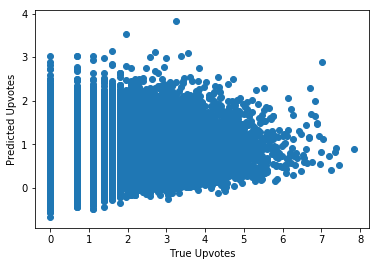

In [79]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Upvotes')
plt.ylabel('Predicted Upvotes')
plt.show()